## Procesameinto EEG

In [110]:
#Librarias
import pandas as pd
import matplotlib.pyplot as plt
import mne
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
import os
import numpy as np
import pywt
from contextlib import redirect_stdout
from scipy.signal import firwin, lfilter, iirnotch, sosfilt, welch, filtfilt


<div style="text-align: justify;font-size: 32px;font-weight: bold;color: #b1c5fc;">
Teoría de señales encefalograficas.
</div>

<br>

<div style="text-align: justify;">
Un <span style="color: #b1c5fc;">electroencefalograma</span> es un examen que registra la actividad eléctrica del cerebro. Se utiliza para evaluar diversas funciones cerebrales, como el sueño, las convulsiones (epilepsia), los tumores cerebrales, los efectos de ciertos medicamentos y otras afecciones neurológicas.
</div>

<br>

<div style="text-align: center;">
<img src="assets\eeg.png">
</div>
<br>


<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">
¿Cómo subir señales EEG?
</div>

<br>

<div style="text-align: justify;">
Tenemos señales EEG generadas por el equipo que estamos utilizando. Estas señales pueden guardarse en varios formatos de archivo <span style="color: #b1c5fc;">(.csv, .txt, .m, .cnt)</span>. En estos archivos, podemos encontrar información sobre el paciente, el equipo, características del test y otros detalles.
</div>

In [97]:
def cargar_archivo_eeg():
    """
    Abre un cuadro de diálogo para seleccionar un archivo .cnt,
    carga el archivo en un objeto MNE Raw, convierte los datos en un DataFrame,
    guarda la metadata en una variable y la retorna junto con el DataFrame.
    """
    # Crear una ventana oculta para usar el selector de archivos
    root = Tk()
    root.withdraw()  # Ocultar la ventana principal
    root.attributes('-topmost', True)  # Asegurarse de que la ventana esté en primer plano

    # Abrir un cuadro de diálogo para seleccionar un archivo .cnt
    archivo_eeg = filedialog.askopenfilename(
        title="Selecciona un archivo CNT",
        filetypes=[("Archivos CNT", "*.cnt")]
    )
    
    # Destruir la ventana oculta después de usarla
    root.destroy()
    
    if archivo_eeg:
        try:
            # Cargar el archivo .cnt
            eeg_data = mne.io.read_raw_cnt(archivo_eeg, preload=True)
            
            # Extraer los datos del EEG y la metadata
            data, _ = eeg_data[:, :]
            df = pd.DataFrame(data.T, columns=eeg_data.info['ch_names'])
            info = eeg_data.info  # Guardar la metadata
            
            # Retornar el DataFrame y la metadata
            return df, info
        
        except Exception as e:
            print(f"Error al cargar el archivo: {str(e)}")
            return None, None

# Ejecutar la función para seleccionar y cargar el archivo .cnt
df_sujeto, info = cargar_archivo_eeg()
if df_sujeto is not None:
    print(df_sujeto.head())  # Mostrar las primeras filas del DataFrame
    print("Metadata del archivo:")
    print(info)  # Mostrar la metadata


Reading 0 ... 3069  =      0.000 ...     7.673 secs...
          1         2         3             4         5         6         7  \
0  0.000074  0.000007  0.000044  5.035400e-07  0.000017  0.000034  0.000011   
1  0.000075  0.000006  0.000044  6.713867e-07  0.000015  0.000035  0.000010   
2  0.000077  0.000006  0.000044  2.433777e-06  0.000015  0.000041  0.000011   
3  0.000078  0.000009  0.000048  5.874634e-06  0.000019  0.000042  0.000014   
4  0.000074  0.000010  0.000051  6.546021e-06  0.000021  0.000039  0.000015   

          8         9        10  ...       111           112       113  \
0  0.000013  0.000053  0.000012  ...  0.000010 -8.392334e-08  0.000015   
1  0.000011  0.000046  0.000010  ...  0.000010  8.392334e-08  0.000014   
2  0.000010  0.000042  0.000011  ...  0.000008 -2.014160e-06  0.000012   
3  0.000015  0.000048  0.000012  ...  0.000007 -2.098083e-06  0.000013   
4  0.000017  0.000045  0.000012  ...  0.000006 -2.685547e-06  0.000012   

        114       115    

C:\Users\DeusWin\AppData\Local\Temp\ipykernel_12916\4089937640.py:24: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg_data = mne.io.read_raw_cnt(archivo_eeg, preload=True)
C:\Users\DeusWin\AppData\Local\Temp\ipykernel_12916\4089937640.py:24: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  eeg_data = mne.io.read_raw_cnt(archivo_eeg, preload=True)


<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">
Metadata
</div>
<br>

<div style="text-align: justify;">
Una vez cargado el archivo lo primero que debemos hacer es conocer la información interna de este, conocido como la <span style="color: #b1c5fc;">METADATA</span>, esto para conocer datos importantes al momento de graficar como el número de canales, la frecuencia de muestreo, el nombre de estos canales, entre otros datos útiles.
</div>

In [98]:
# Imprimir la información de forma más ordenada
print("=== Información IMPORTANTE del Archivo EEG === \n")
print(f"Frecuencia de muestreo:            {info['sfreq']} Hz")
sfreq=info['sfreq']
print(f"Total de canales:                         {info['nchan']}")
print(f"Número de electrodos:               {len(info['dig'])}")
print(f"Bads (canales malos):                 {', '.join(info['bads'])}")
print(f"Total de canales:                         {info['nchan']}")





=== Información IMPORTANTE del Archivo EEG === 

Frecuencia de muestreo:            400.0 Hz
Total de canales:                         128
Número de electrodos:               131
Bads (canales malos):                 LEFT_EAR, VEOGR
Total de canales:                         128


<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">
Graficar una señal única
</div>
<br>

<div style="text-align: justify;">
Una vez cargado el archivo lo primero que debemos hacer es conocer la información interna de este, conocido como la <span style="color: #b1c5fc;">METADATA</span>, esto para conocer datos importantes al momento de graficar como el número de canales, la frecuencia de muestreo, el nombre de estos canales, entre otros datos útiles.
</div>
<br>

<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">
Visualizamos algunos de los canales
</div>
<br>

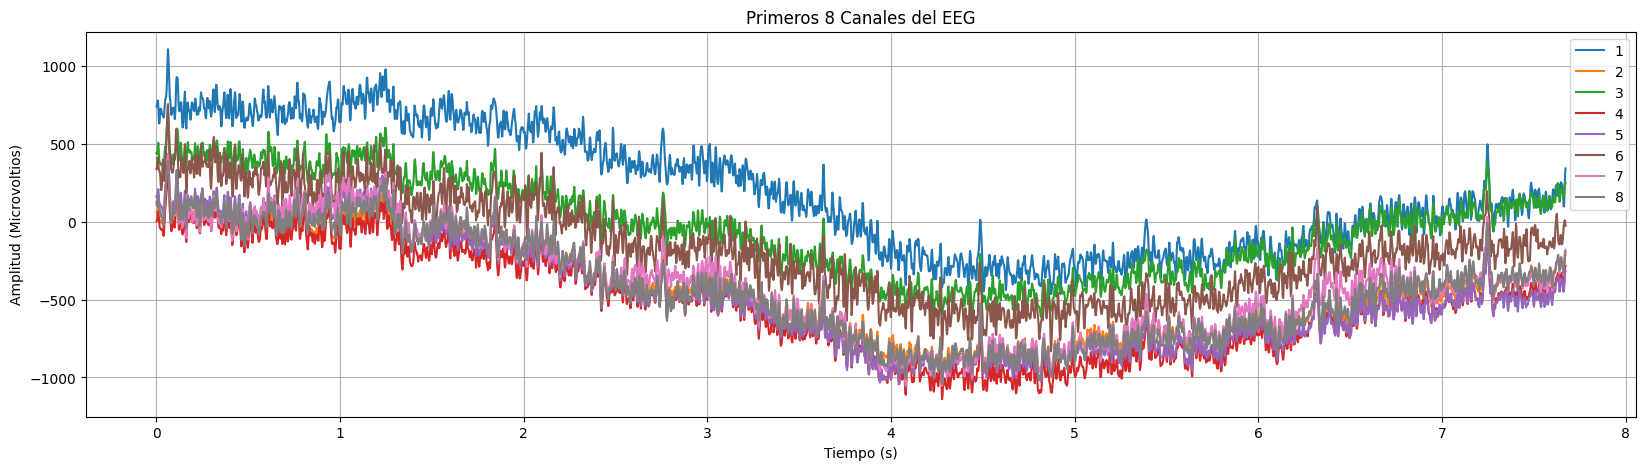

In [99]:
def graficar_eeg(df_sujeto, frecuencia_muestreo=400, canales=8):
    """
    Grafica los primeros 'canales' del DataFrame de EEG.
    
    :param df_sujeto: DataFrame que contiene los datos de EEG.
    :param frecuencia_muestreo: Frecuencia de muestreo en Hz (default 400).
    :param canales: Número de canales a graficar (default 8).
    """
    # Seleccionar las primeras 'canales' columnas
    columnas = df_sujeto.iloc[:, :canales]

    # Crear un eje de tiempo
    tiempo = df_sujeto.index / frecuencia_muestreo

    # Crear una figura y un conjunto de subgráficas
    plt.figure(figsize=(20, 5))

    # Graficar cada columna
    for i, col in enumerate(columnas.columns):
        plt.plot(tiempo, columnas[col] / 0.0000001, label=col)

    # Configurar las etiquetas y el título
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (Microvoltios)')
    plt.title('Primeros 8 Canales del EEG')
    plt.legend()
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()

# Ejemplo de uso
# df_sujeto = pd.read_csv('test_signal.csv')
# graficar_eeg(df_sujeto, 400, 8)

# Llamada a la función
sfreq=info['sfreq']
graficar_eeg(df_sujeto, sfreq, 8)

<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">
Procesamiento y filtrado de la señal
</div>
<br>

<div style="text-align: justify;">
n el contexto del análisis de EEG, los filtros se utilizan para eliminar artefactos, ruido y componentes no deseados de la señal. Por ejemplo, se pueden diseñar filtros para eliminar frecuencias específicas que no están relacionadas con la actividad cerebral de interés, como el ruido de 50/60 Hz proveniente de fuentes eléctricas. La capacidad de los filtros  para proporcionar una respuesta en frecuencia precisa y controlada es crucial para obtener una representación clara y útil de las señales cerebrales.
</div>

<br>

<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">
Visualizamos algunos de los canales ya filtrados
</div>
<br>

In [116]:
def wnoisest(coeff):
    """Estimate noise standard deviation for each wavelet coefficient level."""
    stdc = np.zeros((len(coeff), 1))
    for i in range(1, len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])) / 0.6745)
    return stdc

def thselect(signal):
    """Select threshold value based on universal thresholding."""
    num_samples = 0
    for i in range(len(signal)):
        num_samples += signal[i].shape[0]
    # Universal threshold
    thr = np.sqrt(2 * (np.log(num_samples)))
    return thr

def wthresh(coeff, thr, s):
    """Thresholding function for wavelet coefficients."""
    y = []
    for i in range(len(coeff)):
        y.append(np.multiply(coeff[i], np.abs(coeff[i]) > (thr * s[i])))
    return y

def apply_wavelet_filter(df, wavelet='db1', level=1):
    """
    Apply a wavelet filter to each column in a DataFrame using thresholding.

    Parameters:
    - df: pandas DataFrame with signal data where each column is a separate signal.
    - wavelet: Name of the wavelet to use (default is 'db1').
    - level: Decomposition level (default is 1).

    Returns:
    - filtered_df: DataFrame with wavelet filtered signals.
    """
    filtered_data = {}
    
    for column in df.columns:
        signal = df[column].values
        
        # Decompose the signal using the specified wavelet and level
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        
        # Estimate noise standard deviation for each wavelet coefficient level
        stdc = wnoisest(coeffs)
        
        # Select threshold value based on universal thresholding
        thr = thselect(coeffs)
        
        # Apply thresholding to the wavelet coefficients
        s = np.array([1] * len(coeffs))  # Scaling factor for each level
        coeffs_thresholded = wthresh(coeffs, thr, s)
        
        # Reconstruct the signal from the thresholded coefficients
        filtered_signal = pywt.waverec(coeffs_thresholded, wavelet)
        
        # Ensure the filtered signal is the same length as the original signal
        if len(filtered_signal) > len(signal):
            filtered_signal = filtered_signal[:len(signal)]
        elif len(filtered_signal) < len(signal):
            filtered_signal = np.pad(filtered_signal, (0, len(signal) - len(filtered_signal)), mode='constant')
        
        filtered_data[column] = filtered_signal
    
    filtered_df = pd.DataFrame(filtered_data)
    return filtered_df

def apply_filters(df, low_cutoff=1, high_cutoff=50, notch_freq=None, filter_order=101, fs=400, window='hamming', quality_factor=30):
    """
    Aplica un filtro FIR pasa banda y opcionalmente un filtro notch a todas las columnas de un DataFrame.
    
    Parameters:
    - df: pandas.DataFrame con los datos a filtrar.
    - low_cutoff: frecuencia de corte inferior del filtro pasa banda en Hz.
    - high_cutoff: frecuencia de corte superior del filtro pasa banda en Hz.
    - notch_freq: frecuencia a eliminar con el filtro notch en Hz. Si es None, no se aplica filtro notch.
    - filter_order: orden del filtro FIR pasa banda (debe ser impar).
    - fs: frecuencia de muestreo en Hz.
    - window: tipo de ventana para el diseño del filtro FIR pasa banda (ej. 'hamming', 'blackman').
    - quality_factor: factor de calidad del filtro notch.
    
    Returns:
    - pandas.DataFrame con los datos filtrados.
    """
    
    # Normalizar las frecuencias de corte para el filtro pasa banda
    nyquist = 0.5 * fs
    normal_low_cutoff = low_cutoff / nyquist
    normal_high_cutoff = high_cutoff / nyquist
    
    # Crear el filtro FIR pasa banda
    b_bandpass = firwin(filter_order, [normal_low_cutoff, normal_high_cutoff], pass_zero=False, window=window)
    
    # Aplicar el filtro FIR pasa banda a cada columna
    df_filtered_bandpass = pd.DataFrame()
    for column in df.columns:
        df_filtered_bandpass[column] = filtfilt(b_bandpass, [1.0], df[column])
    
    # Si se proporciona una frecuencia de notch, aplicar el filtro notch
    if notch_freq is not None:
        # Crear el filtro notch
        notch_b, notch_a = iirnotch(notch_freq / nyquist, quality_factor)
        
        # Aplicar el filtro notch a cada columna
        df_filtered = pd.DataFrame()
        for column in df_filtered_bandpass.columns:
            df_filtered[column] = filtfilt(notch_b, notch_a, df_filtered_bandpass[column])
    else:
        df_filtered = df_filtered_bandpass
    
    return df_filtered

# Aplicar los filtros
low_cutoff = 1   # Frecuencia de corte inferior en Hz
high_cutoff = 60 # Frecuencia de corte superior en Hz
notch_freq = 50  # Frecuencia a eliminar con el filtro notch en Hz
df_sujeto_filtrado_fir = apply_filters(df_sujeto, low_cutoff, high_cutoff, notch_freq)
df_sujeto_filtrado_completo = apply_wavelet_filter(df_sujeto_filtrado_fir)




C:\Users\DeusWin\AppData\Local\Temp\ipykernel_12916\3818946302.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered_bandpass[column] = filtfilt(b_bandpass, [1.0], df[column])
C:\Users\DeusWin\AppData\Local\Temp\ipykernel_12916\3818946302.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered_bandpass[column] = filtfilt(b_bandpass, [1.0], df[column])
C:\Users\DeusWin\AppData\Local\Temp\ipykernel_12916\3818946302.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

<div style="text-align: justify;font-size: 28px;color: #b1c5fc;">Calcula la Densidad Espectral de Potencia (PSD)</div>

<br>

<div style="text-align: justify;">
<span style="color: #b1c5fc;">La densidad espectral de potencia (PSD)</span> es crucial para descomponer y analizar señales en términos de sus componentes de <span style="color: #b1c5fc;">frecuencia</span>, permitiendo identificar cómo se distribuye la potencia en <span style="color: #b1c5fc;">diferentes bandas de frecuencia</span>. En EEG, la PSD ayuda a detectar patrones de actividad cerebral asociados con estados cognitivos y emocionales, diagnosticar y monitorear condiciones neurológicas, y desarrollar biomarcadores para estudios clínicos y de investigación. También es útil para detectar anomalías, diseñar filtros para limpiar señales y entender la relación entre el comportamiento y la actividad cerebral.
</div>

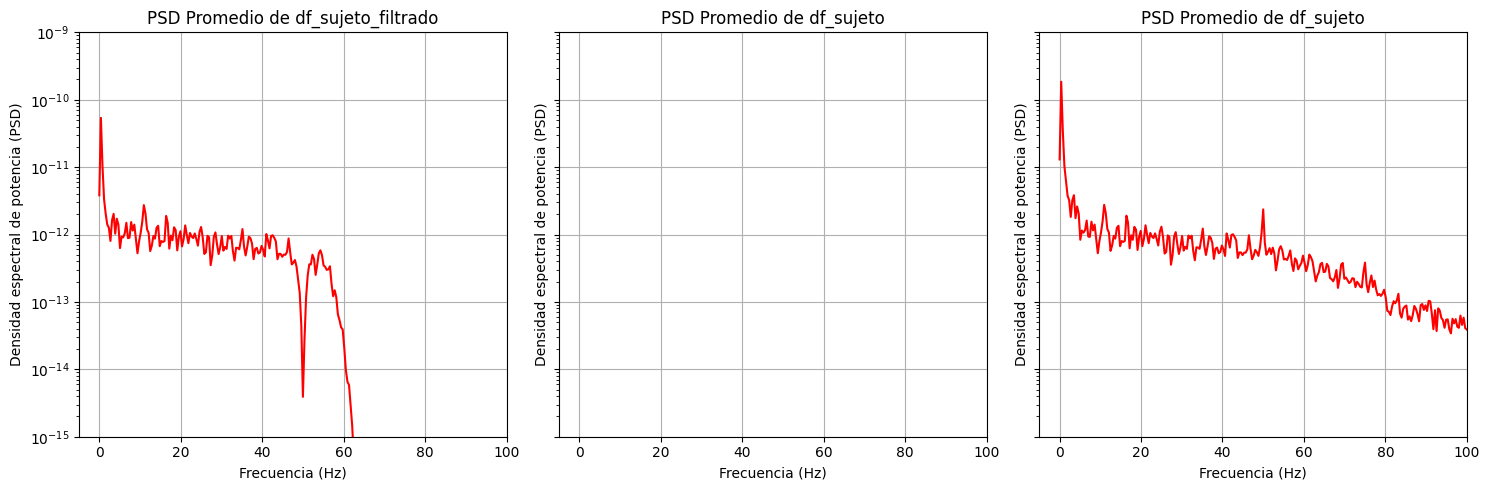

In [118]:
def compute_average_psd(df, fs=400, nperseg=1024, ax=None):
    """
    Calcula el espectro de densidad de potencia (PSD) promedio de todas las columnas de un DataFrame.
    
    Parameters:
    - df: pandas.DataFrame con los datos de señal.
    - fs: frecuencia de muestreo en Hz.
    - nperseg: longitud de cada segmento para el cálculo de Welch. Si es None, se usa el tamaño de la ventana por defecto.
    - ax: objeto de eje para dibujar el gráfico. Si es None, se crea una nueva figura.
    
    Returns:
    - freqs: Array de frecuencias.
    - avg_psd: PSD promedio de todas las columnas.
    """
    
    # Inicializar listas para almacenar PSDs y frecuencias
    psd_list = []
    freqs = None
    
    # Calcular PSD para cada columna
    for col in df.columns:
        f, Pxx = welch(df[col], fs=fs, nperseg=nperseg)
        psd_list.append(Pxx)
        if freqs is None:
            freqs = f
    
    # Calcular PSD promedio
    avg_psd = np.mean(psd_list, axis=0)
    
    # Graficar el PSD promedio
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.gca()
    
    ax.plot(freqs, avg_psd, color='red')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Densidad espectral de potencia (PSD)')
    ax.set_yscale('log')
    ax.set_xlim([-5, 100])
    ax.set_ylim([1e-15, 1e-9])
    ax.set_title('PSD Promedio de Todas las Columnas')
    ax.grid(True)
    
    return freqs, avg_psd
# Crear una figura con dos subgráficas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Graficar el PSD para df_sujeto_filtrado en la primera subgráfica
compute_average_psd(df_sujeto_filtrado_fir, fs=sfreq, ax=ax1)
ax1.set_title('PSD Promedio de df_sujeto_filtrado')

# Graficar el PSD para df_sujeto en la segunda subgráfica
compute_average_psd(df_sujeto_filtrado_completo, fs=sfreq, ax=ax2)
ax2.set_title('PSD Promedio de df_sujeto')

compute_average_psd(df_sujeto, fs=sfreq, ax=ax3)
ax3.set_title('PSD Promedio de df_sujeto')
# Ajustar el diseño
plt.tight_layout()
plt.show()
